In [2]:
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense,Bidirectional,Dropout

In [3]:
df= pd.read_csv("C:\\Users\\mahen\\Downloads\\IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

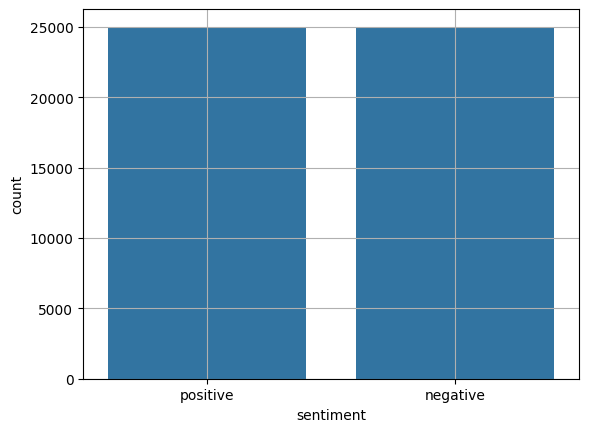

In [6]:
sns.countplot(x=df['sentiment'])
plt.grid()

In [8]:
sentences=df['review']
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

#### Data visualization using word cloud for finding the most used words for each type of sentiment

(-0.5, 799.5, 799.5, -0.5)

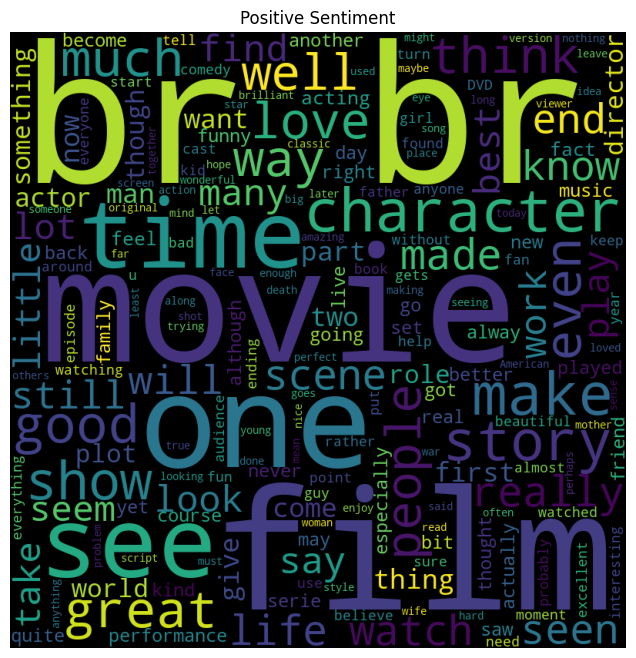

In [9]:
stopwords = set(STOPWORDS) 

pos=' '.join(map(str,sentences[df['sentiment']==1]))
neg=' '.join(map(str,sentences[df['sentiment']==0]))
  
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

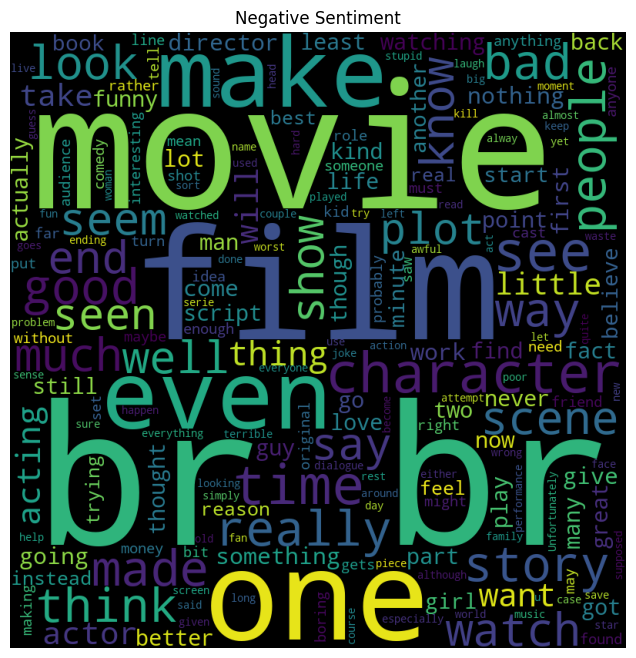

In [11]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show()

In [6]:
import os
%pwd  # this tell us which path we are currently working , so based on the below output path we are working under the research file
os.chdir("C:\datascience End to End Projects\End-to-End-sentimental-analysis-with-NLP")  #  but i would like to work with main ProjectML_with_MLFlow file , so for getting i step back in path inorder to enter the main project file i used this command os.chdir("../")
%pwd

'C:\\datascience End to End Projects\\End-to-End-sentimental-analysis-with-NLP'

In [7]:
# This is called the entity 
from dataclasses import dataclass # here i imported the dataclass from the dataclasses
from pathlib import Path  # here i imported path from pathlib

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path  # these are variables which are present inside the config.yaml file data_transformation code part and here iam mentioning inside the entity of the class
    data_path: Path
    preprocessor_obj: str
    model_file: str

In [8]:
from NLP_PROJECT.constants import *
from NLP_PROJECT.utils.common import read_yaml, create_directories

In [9]:
# this is same part of the code in every step 
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    # only this part get changes in every step, only defining the get_data_transformation_config get changes according to which step we are performing like 01_data_ingestion,02_data_validation
    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,  # here iam returning these 2 varaibles by using this code 
            data_path=config.data_path,
            preprocessor_obj=config.preprocessor_obj,
            model_file=config.model_file,
        )

        return data_transformation_config

In [10]:
import os
from NLP_PROJECT import logger
#from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
import pickle

In [11]:
# here i defined the component of DataTransformationConfig below
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config


    def transform_the_target_feature(self):
        self.df = pd.read_csv(self.config.data_path)
        self.sentences=self.df['review']
        le=LabelEncoder()
        self.df['sentiment']= le.fit_transform(self.df['sentiment'])
        print(le.classes_)
        print(self.df['sentiment']) # according to label encoding transofrmation output 1 means positive , 0 means negative 
        #labels=to_categorical(self.df['sentiment'],num_classes=2)
        #print(labels)


        self.X_train,self.X_test,self.Y_train,self.Y_test = train_test_split(self.df['review'],self.df['sentiment'],test_size=0.1,random_state=10)
        print(f'This is x_train {self.X_train}')
        print(f'this is y_train {self.Y_train}')

        self.glove_embeddings= np.load("C:\\datascience End to End Projects\\capstone\\glove.840B.300d.pkl",
                          allow_pickle=True)
        logger.info("Done with word_cloud and loading the glove")

        return self.X_train,self.X_test,self.glove_embeddings
    

    def clean_sentences(self,line):
        
        line=re.sub('<.*?>','',line) # removing html tags
        
        #removing contractions
        line=re.sub("isn't",'is not',line)
        line=re.sub("he's",'he is',line)
        line=re.sub("wasn't",'was not',line)
        line=re.sub("there's",'there is',line)
        line=re.sub("couldn't",'could not',line)
        line=re.sub("won't",'will not',line)
        line=re.sub("they're",'they are',line)
        line=re.sub("she's",'she is',line)
        line=re.sub("There's",'there is',line)
        line=re.sub("wouldn't",'would not',line)
        line=re.sub("haven't",'have not',line)
        line=re.sub("That's",'That is',line)
        line=re.sub("you've",'you have',line)
        line=re.sub("He's",'He is',line)
        line=re.sub("what's",'what is',line)
        line=re.sub("weren't",'were not',line)
        line=re.sub("we're",'we are',line)
        line=re.sub("hasn't",'has not',line)
        line=re.sub("you'd",'you would',line)
        line=re.sub("shouldn't",'should not',line)
        line=re.sub("let's",'let us',line)
        line=re.sub("they've",'they have',line)
        line=re.sub("You'll",'You will',line)
        line=re.sub("i'm",'i am',line)
        line=re.sub("we've",'we have',line)
        line=re.sub("it's",'it is',line)
        line=re.sub("don't",'do not',line)
        line=re.sub("that´s",'that is',line)
        line=re.sub("I´m",'I am',line)
        line=re.sub("it’s",'it is',line)
        line=re.sub("she´s",'she is',line)
        line=re.sub("he’s'",'he is',line)
        line=re.sub('I’m','I am',line)
        line=re.sub('I’d','I did',line)
        line=re.sub("he’s'",'he is',line)
        line=re.sub('there’s','there is',line)
        
        #special characters and emojis
        line=re.sub('\x91The','The',line)
        line=re.sub('\x97','',line)
        line=re.sub('\x84The','The',line)
        line=re.sub('\uf0b7','',line)
        line=re.sub('¡¨','',line)
        line=re.sub('\x95','',line)
        line=re.sub('\x8ei\x9eek','',line)
        line=re.sub('\xad','',line)
        line=re.sub('\x84bubble','bubble',line)
        
        # remove concated words
        line=re.sub('trivialBoring','trivial Boring',line)
        line=re.sub('Justforkix','Just for kix',line)
        line=re.sub('Nightbeast','Night beast',line)
        line=re.sub('DEATHTRAP','Death Trap',line)
        line=re.sub('CitizenX','Citizen X',line)
        line=re.sub('10Rated','10 Rated',line)
        line=re.sub('_The','_ The',line)
        line=re.sub('1Sound','1 Sound',line)
        line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
        line=re.sub('ResidentHazard','Resident Hazard',line)
        line=re.sub('iameracing','i am racing',line)
        line=re.sub('BLACKSNAKE','Black Snake',line)
        line=re.sub('DEATHSTALKER','Death Stalker',line)
        line=re.sub('_is_','is',line)
        line=re.sub('10Fans','10 Fans',line)
        line=re.sub('Yellowcoat','Yellow coat',line)
        line=re.sub('Spiderbabe','Spider babe',line)
        line=re.sub('Frightworld','Fright world',line)
        
        #removing punctuations
        
        punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
        for p in punctuations:
            line = line.replace(p, f' {p} ')
           
        line=re.sub(',',' , ',line)
           
        # ... and ..
        line = line.replace('...', ' ... ')
        
        if '...' not in line:
            line = line.replace('..', ' ... ')
        
            
        return line
        
    

    def vocab_build(self,review):
        logger.info("Done with cleaning data")
        logger.info("entered the vocab build")
    
        comments = review.apply(lambda s: s.split()).values
        self.vocab={}
        
        for comment in comments:
            for word in comment:
                try:
                    self.vocab[word]+=1
                    
                except KeyError:
                    self.vocab[word]=1
        
        logger.info("done with vocab build")

    def embedding_coverage(self,embeddings):
    
        #self.vocab=self.vocab_build(review)
        
        covered={}
        word_count={}
        oov={}
        covered_num=0
        oov_num=0
        
        for word in self.vocab:
            try:
                covered[word]=embeddings[word]
                covered_num+=self.vocab[word]
                word_count[word]=self.vocab[word]
            except:
                oov[word]=self.vocab[word]
                oov_num+=oov[word]
        
        vocab_coverage=len(covered)/len(self.vocab)*100
        text_coverage = covered_num/(covered_num+oov_num)*100
        
        sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
        sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
        
        return sorted_word_count,sorted_oov,vocab_coverage,text_coverage
        





    def embedding_coverage_test(self,train_covered, train_oov, train_vocab_coverage, train_text_coverage):
        self.train_test_covered = train_covered
        self.train_test_oov = train_oov
        self.train_test_vocab_coverage = train_vocab_coverage
        self.train_test_text_coverage = train_text_coverage

        print(f"Glove embeddings cover {round(self.train_test_vocab_coverage,2)}% of vocabulary and {round(self.train_test_text_coverage,2)}% text in training set")

        return self.train_test_covered,self.train_test_oov


    def train_word_and_train_word_count(self,train_covered):
        self.punctuations = '@#!~?+&*[]-%._-:/£();$=><|{},^' + '''"“´”'`'''
        train_word=[]
        train_count=[]

        i=1
        for word,count in train_covered: 
            if word not in self.punctuations:
                train_word.append(word)
                train_count.append(count)
                i+=1
            if(i==15):
                break

    def test_word_and_test_word_count(self,test_covered):
        test_word=[]
        test_count=[]

        i=1
        for word,count in test_covered: 
            if word not in self.punctuations:
                test_word.append(word)
                test_count.append(count)
                i+=1
            if(i==15):
                break

    def deleting_out_of_vocab(self,train_oov,test_oov):
        if self.glove_embeddings is not None:
            del self.glove_embeddings
        if hasattr(self, 'train_oov'):  # Check if train_oov is defined
            del train_oov
        if hasattr(self, 'test_oov'):  # Check if test_oov is defined
            del test_oov
        gc.collect()


    def find_vocab_word_count(self,X_train_cln):
        self.num_words=80000
        self.embeddings=256
        self.tokenizer=Tokenizer(num_words=self.num_words,oov_token='<OOV>')
        self.tokenizer.fit_on_texts(X_train_cln)
        word_index=self.tokenizer.word_index
        total_vocab=len(word_index)
        print("Vocabulary of the dataset is : ",total_vocab)


    def creating_train_and_test_pad(self):
        
        sequences_train=self.tokenizer.texts_to_sequences(self.X_train)
        sequences_test=self.tokenizer.texts_to_sequences(self.X_test)
        
        with open(os.path.join(self.config.root_dir, self.config.preprocessor_obj), 'wb') as tokenizer_pkl_file:
            pickle.dump(self.tokenizer, tokenizer_pkl_file)

        max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_test]))
        print(f'the max_len is {max_len}')
        train_padded = pad_sequences(sequences_train, maxlen=max_len)
        test_padded = pad_sequences(sequences_test, maxlen=max_len)
    
        X_train,X_val,Y_train,Y_val=train_test_split(train_padded,self.Y_train,
                                             test_size=0.05,random_state=10)

        model = keras.Sequential()
        model.add(Embedding(self.num_words, self.embeddings, input_shape=(max_len,)))
        model.add(Conv1D(256, 10, activation='relu'))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(LSTM(64))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()


        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

        # here i need to add early stopping if need based on my model performance

        logger.info("initiated model training")

        history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=5,batch_size=32)

        logger.info("Done with model Training")
        model.save(os.path.join(self.config.root_dir, self.config.model_file))


        return history

    def plot_graph(history,string):
    
        plt.plot(history.history[string],label='training '+string)
        plt.plot(history.history['val_'+string],label='validation '+string)
        plt.legend()
        plt.xlabel('epochs')
        plt.ylabel(string)
        plt.title(string+' vs epochs')
        plt.show()



In [12]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    x_train,x_test,glove_embeddings=data_transformation.transform_the_target_feature()
    X_train_cleaned = data_transformation.X_train.apply(lambda s: data_transformation.clean_sentences(s))  # Corrected usage without 'self'
    X_test_cleaned = data_transformation.X_test.apply(lambda s: data_transformation.clean_sentences(s))  # Corrected usage without 'self'
    data_transformation.vocab_build(X_train_cleaned)  # Pass the required parameter here
    train_covered, train_oov, train_vocab_coverage, train_text_coverage = data_transformation.embedding_coverage(glove_embeddings)  # Pass the required parameters here
    train_covered_for_word_count,train_data_oov=data_transformation.embedding_coverage_test(train_covered, train_oov, train_vocab_coverage, train_text_coverage)
    data_transformation.vocab_build(X_test_cleaned)
    test_covered, test_oov, test_vocab_coverage, test_text_coverage = data_transformation.embedding_coverage(glove_embeddings)  # Pass the required parameters here
    test_covered_for_word_count,test_data_oov=data_transformation.embedding_coverage_test(test_covered, test_oov, test_vocab_coverage, test_text_coverage)    
    data_transformation.train_word_and_train_word_count(train_covered_for_word_count)
    data_transformation.test_word_and_test_word_count(test_covered_for_word_count)
    data_transformation.deleting_out_of_vocab(train_data_oov,test_data_oov)
    data_transformation.find_vocab_word_count(X_train_cleaned)
    history=data_transformation.creating_train_and_test_pad()
    data_transformation.plot_graph(history,'loss')
    data_transformation.plot_graph(history,'accuracy')


except Exception as e: # this part of code will raise error if anything goes wrong
    raise e


[2024-04-15 16:26:34,161: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-04-15 16:26:34,175: INFO: common: yaml file: params.yaml loaded successfully]
[2024-04-15 16:26:34,191: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-04-15 16:26:34,195: INFO: common: created directory at: artifacts]
[2024-04-15 16:26:34,199: INFO: common: created directory at: artifacts/data_transformation]


['negative' 'positive']
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int32
This is x_train 10830    It's here. finally a movie comes out that I ca...
49761    To most of us, life is an unfolding process of...
36139    Rated PG-13 for violence, brief sexual humor a...
2787     Geez! This is one of those movies that you thi...
7612     For anyone who has ever sought happiness, "Hal...
                               ...                        
40059    This film is just a shame. Orlando, Florida se...
28017    Having seen Versus previously I had high hopes...
29199    I must admit I burst out laughing when I saw o...
40061    You can find an anti-war statement here withou...
17673    Mr Seagal has apparantly lowered his (already ...
Name: review, Length: 45000, dtype: object
this is y_train 10830    0
49761    1
36139    1
2787     0
7612     1
        ..
40059    0
28017    